
Целью этого блокнота является создание модели прогнозирования, которая учитывает метаданные о пациенте и образцах в виде кривых ЭКГ. Целевыми объектами для модели будут суперклассы, определенные набором данных.

Суперклассы, перечисленные в описании набора данных, следующие:

```
Записей | Superclass | Description
9528 | NORM | ЭКГ в норме
5486 | MI | Инфаркт миокарда
5250 | STTC | ST/T Change
4907 | CD | Нарушенный ритм
2655 | HYP | Гипертрофия
```

In [7]:
"""!pip install D:\Python_proj\test2\modules\wfdb-4.1.2-py3-none-any.whl"""

'!pip install D:\\Python_proj\test2\\modules\\wfdb-4.1.2-py3-none-any.whl'

In [8]:
import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras

sns.set_style('darkgrid')

Прежде всего, мне нужно загрузить метаданные о пациентах и образцах, предоставленные набором данных. Все метаданные будут загружены в **ECG_df** и **SCP_df** фреймы данных соответственно.

In [9]:
PATH_TO_DATA = r"D:\Python_proj\test2\innopolis\ITOG\second\second\ECG_data\"

ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x: ast.literal_eval(x))
ECG_df.patient_id = ECG_df.patient_id.astype(int)
ECG_df.nurse = ECG_df.nurse.astype('Int32')  #64
ECG_df.site = ECG_df.site.astype('Int32')  #64
ECG_df.validated_by = ECG_df.validated_by.astype('Int32') #64

SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP_df = SCP_df[SCP_df.diagnostic == 1]

ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709,56.0,1,NaN,63.0,2,0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243,19.0,0,NaN,70.0,2,0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372,37.0,1,NaN,69.0,2,0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014,24.0,0,NaN,82.0,2,0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448,19.0,1,NaN,70.0,2,0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67.0,1,NaN,NaN,1,2,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703,93.0,0,NaN,NaN,1,2,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311,59.0,1,NaN,NaN,1,2,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


Образцы ЭКГ разбиты на 10 групп. Авторы набора данных ЭКГ PTB-XL предлагают использовать первые 8 групп в качестве обучающих выборок. Последние две группы затем используются в качестве набора образцов для проверки и тестирования. 
Я приму это предложение в своей следующей работе.

In [12]:
#print(ECG_df.columns)
ECG_df.strat_fold.value_counts()

10    2203
3     2194
9     2193
2     2184
8     2179
7     2178
6     2178
1     2177
5     2176
4     2175
Name: strat_fold, dtype: int64

Я собираюсь добавить еще один столбец scp_classes в набор данных ECG_df, который представляет все суперклассы (в виде списка сокращений), присвоенные выборке кардиологами.

In [13]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in SCP_df.index:
            res.add(SCP_df.loc[k].diagnostic_class)
    return list(res)
                    
ECG_df['scp_classes'] = ECG_df.scp_codes.apply(diagnostic_class)


И, наконец, я собираюсь загрузить данные строк (кривые ЭКГ) в набор данных **ECG_data**.

In [95]:
ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,scp_classes
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709,56.0,1,NaN,63.0,2,0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243,19.0,0,NaN,70.0,2,0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372,37.0,1,NaN,69.0,2,0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014,24.0,0,NaN,82.0,2,0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448,19.0,1,NaN,70.0,2,0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67.0,1,NaN,NaN,1,2,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703,93.0,0,NaN,NaN,1,2,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311,59.0,1,NaN,NaN,1,2,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


In [96]:
ECG_data

array([[[-1.190e-01, -5.500e-02,  6.400e-02, ..., -2.600e-02,
         -3.900e-02, -7.900e-02],
        [-1.160e-01, -5.100e-02,  6.500e-02, ..., -3.100e-02,
         -3.400e-02, -7.400e-02],
        [-1.200e-01, -4.400e-02,  7.600e-02, ..., -2.800e-02,
         -2.900e-02, -6.900e-02],
        ...,
        [ 6.900e-02,  0.000e+00, -6.900e-02, ...,  2.400e-02,
         -4.100e-02, -5.800e-02],
        [ 8.600e-02,  4.000e-03, -8.100e-02, ...,  2.420e-01,
         -4.600e-02, -9.800e-02],
        [ 2.200e-02, -3.100e-02, -5.400e-02, ...,  1.430e-01,
         -3.500e-02, -1.200e-01]],

       [[ 4.000e-03,  1.380e-01,  1.340e-01, ...,  1.920e-01,
          8.300e-02,  8.800e-02],
        [-2.000e-02,  1.160e-01,  1.360e-01, ...,  1.560e-01,
          5.700e-02,  6.300e-02],
        [-5.300e-02,  9.200e-02,  1.450e-01, ...,  1.070e-01,
          1.300e-02,  2.200e-02],
        ...,
        [ 1.210e-01,  3.980e-01,  2.770e-01, ..., -1.065e+00,
         -4.920e-01, -1.560e-01],
        [-3.

In [14]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate = 100

ECG_data = load_raw_data(ECG_df, sampling_rate, PATH_TO_DATA)

ECG_data.shape

(21837, 1000, 12)

Теперь у меня есть все данные из набора данных ЭКГ PTB-XL, загруженные в фреймы данных Pandas или массивы numpy. Так что я могу коротко взглянуть на них.
В качестве примера я хотел бы показать только один образец из набора данных ECG_data:

In [16]:
#ECG_data

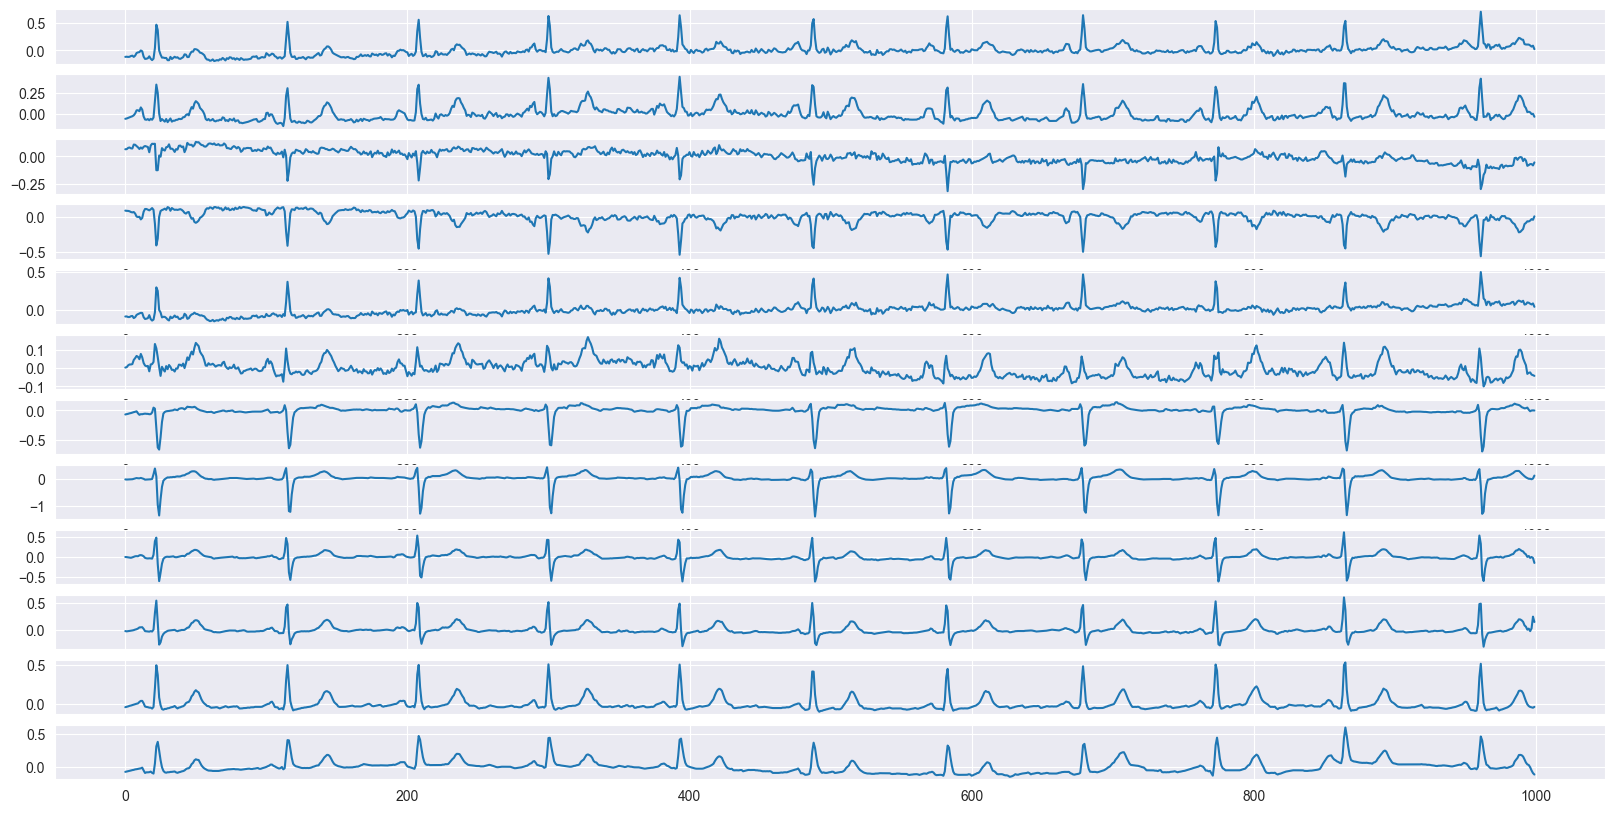

In [17]:
sample = ECG_data[0]
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20,10))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
# plt.tight_layout()
plt.show()

Первая проблема, с которой я хотел бы справиться, - это нулевые значения во фрейме данных метаданных. Вот краткий обзор проблемы:

In [32]:
print("Total Null values %: ")
print(ECG_df.isnull().sum())

Total Null values %: 
patient_id                          0
age                                89
sex                                 0
height                          14854
weight                          12408
nurse                            1509
site                               18
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8505
infarction_stadium1             16211
infarction_stadium2             21734
validated_by                     9411
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  20230
static_noise                    18575
burst_noise                     21224
electrodes_problems             21807
extra_beats                     19883
pacemaker                       21544
strat_fold                          0
filename_lr                 

In [114]:
ECG_df.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'scp_classes'],
      dtype='object')

In [19]:
ECG_df.describe()

,patient_id,age,sex,height,weight,nurse,site,validated_by,strat_fold
count,21837.000000,21748.000000,21837.000000,6983.000000,9429.000000,20328.0,21819.0,12426.0,21837.000000
mean,11255.005953,59.836307,0.478912,166.708292,70.997561,2.292503,1.547229,0.747948,5.505335
std,6234.132489,16.953125,0.499567,10.864935,15.875146,3.254786,4.169753,1.183269,2.875306
min,302.000000,2.000000,0.000000,6.000000,5.000000,0.0,0.0,0.0,1.000000
25%,5982.000000,50.000000,0.000000,160.000000,60.000000,0.0,0.0,0.0,3.000000
50%,11423.000000,62.000000,0.000000,166.000000,70.000000,1.0,1.0,1.0,6.000000
75%,16614.000000,72.000000,1.000000,174.000000,80.000000,3.0,2.0,1.0,8.000000
max,21797.000000,95.000000,1.000000,209.000000,250.000000,11.0,50.0,11.0,10.000000


И чтобы добавить еще один угол обзора, есть обзор уникальных значений во всех столбцах фрейма данных метаданных:

In [33]:
ECG_df[[col for col in ECG_df.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

patient_id                      18885
age                                94
sex                                 2
height                             77
weight                            127
nurse                              12
site                               51
device                             11
recording_date                  21813
report                           9883
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    321
static_noise                      124
burst_noise                       103
electrodes_problems                14
extra_beats                       128
pacemaker                           4
strat_fold                         10
filename_lr                     21837
filename_hr                     21837
dtype: int64

# Подготовка данных для моделирования

Сначала мне нужно подготовить входные и выходные данные (целевые показатели) для моих моделей. 

В качестве входных данных я буду использовать как метаданные пациента (теперь загруженные во фрейм данных ECG_df), так и кривые ЭКГ (в массиве ECG_data numpy) соответственно. Но оба требуют некоторой доработки, чтобы быть полезными для моделирования, что будет сделано в следующих нескольких шагах.

В качестве выходных данных я создам новый фрейм данных со строками, равными выборкам, и столбцами, соответствующими суперклассам диагностики.

Поскольку у меня будет два входа и один выход, я предварительно исправлю все созданные фреймы данных следующим образом:
- X - префикс для метаданных пациента и образца
- Y - префикс для кривых ЭКГ
- Z - префикс для целевых показателей

## X dataframe ...

Я не буду использовать все столбцы из ECG_df dataframe, а только их подмножество. 
Созданный фрейм данных **X** содержит только столбцы, которые связаны с пациентом и состоянием его здоровья. Во время создания фрейма данных я буду работать с нулевыми значениями и сопоставлять категориальные столбцы с числовым представлением.

In [101]:
X = pd.DataFrame(index=ECG_df.index)

X['age'] = ECG_df.age
X.age.fillna(0, inplace=True)

X['sex'] = ECG_df.sex.astype(float)
X.sex.fillna(0, inplace=True)

X['height'] = ECG_df.height
X.loc[X.height < 50, 'height'] = np.nan
X.height.fillna(0, inplace=True)

X['weight'] = ECG_df.weight
X.weight.fillna(0, inplace=True)

X['infarction_stadium1'] = ECG_df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ECG_df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

X

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,pacemaker
ecg_id,,,,,,,
1,56.0,1.0,0.0,63.0,0.0,0.0,0.0
2,19.0,0.0,0.0,70.0,0.0,0.0,0.0
3,37.0,1.0,0.0,69.0,0.0,0.0,0.0
4,24.0,0.0,0.0,82.0,0.0,0.0,0.0
5,19.0,1.0,0.0,70.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
21833,67.0,1.0,0.0,0.0,0.0,0.0,0.0
21834,93.0,0.0,0.0,0.0,4.0,0.0,0.0
21835,59.0,1.0,0.0,0.0,0.0,0.0,0.0


## Y фрейм данных ...

Не нужно изменять данные в фрейме данных ECF_data, поэтому я буду использовать его как есть.

## Z целевых объектов ...

Я собираюсь создать **Z** фрейм данных со столбцами, соответствующими суперклассам diagnoses.

In [102]:
Z = pd.DataFrame(0, index=ECG_df.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in ECG_df.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


## Разделение для train, validate и test

Как предполагают авторы набора данных ЭКГ PTB-XL, я разделю весь входной и выходной набор данных на обучающие, валидационные и тестовые подмножества в соответствии со столбцом *strat_fold*.

In [103]:
X_train, Y_train, Z_train = X[ECG_df.strat_fold <= 8],  ECG_data[X[ECG_df.strat_fold <= 8].index - 1],  Z[ECG_df.strat_fold <= 8]
X_valid, Y_valid, Z_valid = X[ECG_df.strat_fold == 9],  ECG_data[X[ECG_df.strat_fold == 9].index - 1],  Z[ECG_df.strat_fold == 9]
X_test,  Y_test,  Z_test  = X[ECG_df.strat_fold == 10], ECG_data[X[ECG_df.strat_fold == 10].index - 1], Z[ECG_df.strat_fold == 10]

print(X_train.shape, Y_train.shape, Z_train.shape)
print(X_valid.shape, Y_valid.shape, Z_valid.shape)
print(X_test.shape,  Y_test.shape,  Z_test.shape)

(17441, 7) (17441, 1000, 12) (17441, 5)
(2193, 7) (2193, 1000, 12) (2193, 5)
(2203, 7) (2203, 1000, 12) (2203, 5)


In [108]:
ECG_df[ECG_df.strat_fold == 10]

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,scp_classes
ecg_id,,,,,,,,,,,,,,,,,,,,,
9,18792,55.0,0,NaN,70.0,2,0,CS-12 E,1984-12-08 09:44:43,sinusrhythmus normales ekg,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,[NORM]
38,17076,40.0,0,NaN,72.0,2,0,CS-12 E,1985-02-15 11:48:22,sinusrhythmus schwierig bestimmbare qrs-achse,...,NaN,", alles,",V5,NaN,NaN,NaN,10,records100/00000/00038_lr,records500/00000/00038_hr,[NORM]
40,19501,60.0,0,NaN,85.0,2,0,CS-12 E,1985-02-20 11:43:45,sinusrhythmus linkstyp sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/00000/00040_lr,records500/00000/00040_hr,[NORM]
57,16063,26.0,0,NaN,93.0,2,0,CS-12 E,1985-06-06 11:32:43,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,[NORM]
59,19475,54.0,0,NaN,67.0,2,0,CS-12 E,1985-06-12 06:36:01,sinusrhythmus normales ekg,...,", V1",", V1,",NaN,NaN,NaN,NaN,10,records100/00000/00059_lr,records500/00000/00059_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21809,12931,69.0,1,NaN,NaN,1,2,AT-60 3,2001-02-18 12:36:54,sinusrhythmus linkstyp qrs(t) abnorm inferi...,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/21000/21809_lr,records500/21000/21809_hr,[NORM]
21812,20789,67.0,0,NaN,NaN,1,2,AT-60 3,2001-02-21 13:34:15,supraventrikulÄre arrhythmie a-v block i p-ver...,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/21000/21812_lr,records500/21000/21812_hr,[CD]
21818,19204,84.0,1,NaN,NaN,1,2,AT-60 3,2001-03-03 12:09:05,sinusrhythmus linkstyp mÄssige amplitudenkrite...,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/21000/21818_lr,records500/21000/21818_hr,[NORM]


## Стандартизация всех входных наборов данных

In [94]:
from sklearn.preprocessing import StandardScaler
import joblib



X_scaler = StandardScaler()
X_scaler.fit(X_train)
#dump(r"D:\Python_proj\test2\innopolis/ITOG/second/", 'X_scaler.bin', compress=True)
joblib.dump(X_scaler, r'D:\Python_proj\test2\innopolis/ITOG/second/X_scaler.save') 
X_scaler = joblib.load(r'D:\Python_proj\test2\innopolis/ITOG/second/X_scaler.save') 
#X_scaler = joblib.load(r'D:\Python_proj\test2\innopolis/ITOG/second/X_scaler.save') 

X_train = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(X_scaler.transform(X_valid), columns=X_valid.columns)
X_test  = pd.DataFrame(X_scaler.transform(X_test),  columns=X_test.columns)

In [44]:
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))
joblib.dump(Y_scaler, r'D:\Python_proj\test2\innopolis/ITOG/second/Y_scaler.save') 
#Y_scaler = joblib.load(r'D:\Python_proj\test2\innopolis/ITOG/second/Y_scaler.save') 

Y_train = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_valid = Y_scaler.transform(Y_valid.reshape(-1, Y_valid.shape[-1])).reshape(Y_valid.shape)
Y_test  = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

## Сохраним все данные в файл NPZ
Выполнение всех предыдущих шагов заняло некоторое время. Загрузка всех необработанных данных обычно занимает много времени. Поэтому я решил сохранить все подготовленные данные в файл и использовать их позже для своих экспериментов с различными моделями.

In [47]:
NUMPY_DATA_FILE = r'D:\Python_proj\test2\innopolis/ITOG/second/data.npz'

save_args = {
    'X_train': X_train.to_numpy().astype('float32'),
    'X_valid': X_valid.to_numpy().astype('float32'),
    'X_test':  X_test.to_numpy().astype('float32'),
    'Y_train': Y_train.astype('float32'), 
    'Y_valid': Y_valid.astype('float32'),
    'Y_test':  Y_test.astype('float32'),
    'Z_train': Z_train.to_numpy().astype('float32'), 
    'Z_valid': Z_valid.to_numpy().astype('float32'),
    'Z_test':  Z_test.to_numpy().astype('float32'),
}
np.savez(NUMPY_DATA_FILE, **save_args)

# os.remove(NUMPY_DATA_FILE)

# Модели для метаданных и строк кривых ЭКГ

Целями для всех моделей будут диагностические суперклассы, присвоенные каждому образцу. В связи с тем, что один образец может быть помечен одним или несколькими суперклассами, я буду искать ** классификацию с несколькими метками**.
Для оценки того, насколько успешно я работаю со своими моделями, я буду использовать предпочтительно метрику **двоичной точности **.

# Models for metadata and row ECG curves

Targets for all models will be diagnosis superclasses assigned to every sample. Due to the fact, that a single sample can be marked by one o more superclasses, I will look for a **multilabel classification**.
For evaluation how succesful I am with my models, I will use preferably **binary accuracy** metric.

In [48]:
import sys
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

sns.set_style('darkgrid')

I can read all prepared data at previous steps from NPZ file. This is useful, when I want to spare some work already done.

Я могу прочитать все подготовленные данные на предыдущих шагах из файла NPZ. Это полезно, когда я хочу сэкономить на уже проделанной работе.

In [53]:
NUMPY_DATA_FILE = r'D:\Python_proj\test2\innopolis/ITOG/second/data.npz'

thismodule = sys.modules[__name__]
#print(thismodule)
with np.load(NUMPY_DATA_FILE) as data:
    for k in data.keys():
        setattr(thismodule, k, data[k].astype(float))
#data

## Базовый уровень эталонной модели
Прежде чем я перейду к реальному моделированию, я хотел бы создать несколько наивных моделей в качестве эталона для последующего сравнения.
Первая наивная модель, которую я пытаюсь оценить: всем образцам присвоен диагностический суперкласс "НОРМА", поскольку этот класс представлен чаще всего.

In [54]:
z1 = np.zeros(Z_test.shape)
z1[:, 0] = 1

m = keras.metrics.BinaryAccuracy()
m.update_state(Z_test, z1)
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.72074443>

И вторая эталонная модель: всем выборкам присвоены суперклассы в соответствии с вероятностью их представления в подмножестве поездов.

In [55]:
z_prob = Z_train.sum(axis=0) / Z_train.shape[0]
z2 = np.random.uniform(size=Z_test.shape)

for i in range(z2.shape[-1]):
    z2[:, i] = (z2[:, i] < z_prob[i]).astype('float64')
    
m = keras.metrics.BinaryAccuracy()
m.update_state(Z_test, z2)
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.6389469>

## X Классификатор 

Это первая модель, которую я хотел бы оценить. Я пытаюсь сделать прогноз на основе метаданных пациента и выборки - набора данных X.

Модель довольно проста. Он состоит из двух полностью соединенных плотных слоев, дополненных выпадающими слоями регуляризации. Я буду использовать эту модель в своей последующей работе, поэтому будет разумно подготовить для нее функцию:

In [56]:
def create_X_model(X, *, units=32, dropouts=0.3):
    
    X = keras.layers.Dense(units, activation='relu', name='X_dense_1')(X)
    X = keras.layers.Dropout(dropouts, name='X_drop_1')(X)
    X = keras.layers.Dense(units, activation='relu', name='X_dense_2')(X)
    X = keras.layers.Dropout(dropouts, name='X_drop_2')(X)
    
    return X

I would like to evaluate it, so I need complete model with additional Dense layers, regularization and final Dense layer with *sigmoid* activation function.

Я хотел бы оценить это, поэтому мне нужна полная модель с дополнительными плотными слоями, регуляризацией и конечным плотным слоем с функцией активации *sigmoid*.

In [57]:
def create_model01(X_shape, Z_shape):
    X_inputs = keras.Input(X_shape[1:], name='X_inputs')

    X = create_X_model(X_inputs)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=X_inputs, outputs=outputs, name='model01')
    return model

**model01** создана, скомпилирована и представлена в виде резюме...

In [58]:
model01 = create_model01(X_train.shape, Z_train.shape)
model01.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model01.summary()

Model: "model01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 X_inputs (InputLayer)       [(None, 7)]               0         
                                                                 
 X_dense_1 (Dense)           (None, 32)                256       
                                                                 
 X_drop_1 (Dropout)          (None, 32)                0         
                                                                 
 X_dense_2 (Dense)           (None, 32)                1056      
                                                                 
 X_drop_2 (Dropout)          (None, 32)                0         
                                                                 
 Z_dense_1 (Dense)           (None, 64)                2112      
                                                                 
 Z_dense_2 (Dense)           (None, 64)                4160

Model fitting will be stopped, when it ceases to improve. Then model with best results is read from checkpoint file.
Подгонка модели будет остановлена, когда она перестанет улучшаться. Затем из файла контрольной точки считывается модель с наилучшими результатами.

In [59]:
MODEL_CHECKPOINT = r"D:\Python_proj\test2\innopolis\ITOG\second\calc/model01.keras"#'/kaggle/working/model/model01.keras'

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=10),
    keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_binary_accuracy', save_best_only=True)
]

history = model01.fit(X_train, Z_train, epochs=40, batch_size=32, callbacks=callbacks_list, validation_data=(X_valid, Z_valid))

model01 = keras.models.load_model(MODEL_CHECKPOINT)

Epoch 1/40
546/546 [==============================] - 4s 3ms/step - loss: 0.5158 - binary_accuracy: 0.7693 - precision: 0.6222 - recall: 0.2414 - val_loss: 0.4699 - val_binary_accuracy: 0.7927 - val_precision: 0.7304 - val_recall: 0.2997
Epoch 2/40
546/546 [==============================] - 1s 3ms/step - loss: 0.4821 - binary_accuracy: 0.7894 - precision: 0.7324 - recall: 0.2732 - val_loss: 0.4677 - val_binary_accuracy: 0.7926 - val_precision: 0.7470 - val_recall: 0.2854
Epoch 3/40
546/546 [==============================] - 1s 3ms/step - loss: 0.4756 - binary_accuracy: 0.7922 - precision: 0.7482 - recall: 0.2783 - val_loss: 0.4662 - val_binary_accuracy: 0.7935 - val_precision: 0.7358 - val_recall: 0.3000
Epoch 4/40
546/546 [==============================] - 1s 3ms/step - loss: 0.4727 - binary_accuracy: 0.7936 - precision: 0.7549 - recall: 0.2814 - val_loss: 0.4668 - val_binary_accuracy: 0.7939 - val_precision: 0.7431 - val_recall: 0.2961
Epoch 5/40
546/546 [============================

And finally you can see the fitting history with loss functions and metrics:

И, наконец, вы можете просмотреть историю подбора с функциями потерь и метриками:

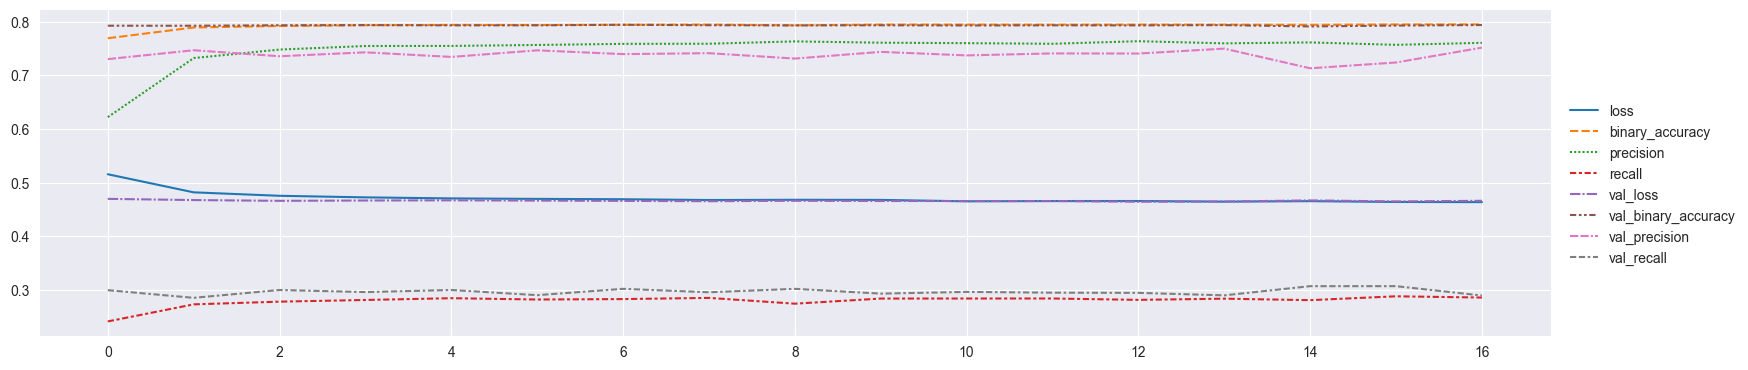

In [60]:
sns.relplot(data=pd.DataFrame(history.history), kind='line', height=4, aspect=4)
plt.show()

Я пытаюсь оценить модель по тестовому набору данных. Как вы можете видеть, я могу получить лучшие результаты, чем при использовании наивных моделей. Так что это не лучший результат, который я могу получить, но он полезен.


In [61]:
model01.evaluate(X_test, Z_test)

69/69 [==============================] - 0s 1ms/step - loss: 0.4616 - binary_accuracy: 0.7970 - precision: 0.7534 - recall: 0.2999


[0.4616037905216217,
 0.7970041632652283,
 0.7533632516860962,
 0.2998929023742676]

## X и Y: Классификатор CNN 1D

Теперь я перехожу к сути своей работы - 1D-модели свертки кривых ЭКГ, улучшенной с помощью model for metadata.

Сначала мне нужна модель для кривых. Еще раз это функция, которая создает три слоя Conv1D, дополненных слоями нормализации и активации. Слои разделены слоями MaxPool1D, которые уменьшают размерность временных рядов входного тензора. С другой стороны, слои Conv1D содержат растущее число фильтров, поэтому размер объекта расширяется. Вся модель завершается уровнем GlobalAveragePooling1D (важны только функции) и регуляризацией выпадения.

И есть функция:

In [62]:
def create_Y_model(X, *, filters=(32, 64, 128), kernel_size=(5, 3, 3), strides=(1, 1, 1)):
    
    f1, f2, f3 = filters
    k1, k2, k3 = kernel_size
    s1, s2, s3 = strides
    
    X = keras.layers.Conv1D(f1, k1, strides=s1, padding='same', name='Y_conv_1')(X)
    X = keras.layers.BatchNormalization(name='Y_norm_1')(X)
    X = keras.layers.ReLU(name='Y_relu_1')(X)

    X = keras.layers.MaxPool1D(2, name='Y_pool_1')(X)

    X = keras.layers.Conv1D(f2, k2, strides=s2, padding='same', name='Y_conv_2')(X)
    X = keras.layers.BatchNormalization(name='Y_norm_2')(X)
    X = keras.layers.ReLU(name='Y_relu_2')(X)

    X = keras.layers.MaxPool1D(2, name='Y_pool_2')(X)

    X = keras.layers.Conv1D(f3, k3, strides=s3, padding='same', name='Y_conv_3')(X)
    X = keras.layers.BatchNormalization(name='Y_norm_3')(X)
    X = keras.layers.ReLU(name='Y_relu_3')(X)

    X = keras.layers.GlobalAveragePooling1D(name='Y_aver')(X)
    X = keras.layers.Dropout(0.5, name='Y_drop')(X)

    return X

Теперь я перейду к объединению моделей кривых ЭКГ и метаданных пациента в одну всеобъемлющую модель.

Существует два входных значения, наборы данных X и Y, и один выходной Z. Я объединю модели для метаданных и кривых ЭКГ. Результат объединения будет передан в два полностью соединенных плотных слоя, за которыми последует отсев и окончательный плотный слой с активацией *sigmoid*. И это все.

In [63]:
def create_model02(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(Y_shape[1:], name='Y_inputs')

    X = keras.layers.Concatenate(name='Z_concat')([create_X_model(X_inputs), create_Y_model(Y_inputs, filters=(64, 128, 256), kernel_size=(7, 3, 3))])
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='model02')
    return model

I can create model **model02**, compile it, and show its summary:

Я могу создать модель **model02**, скомпилировать ее и показать ее краткое описание:

In [66]:
model02 = create_model02(X_train.shape, Y_train.shape, Z_train.shape)
model02.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model02.summary()

Model: "model02"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Y_inputs (InputLayer)          [(None, 1000, 12)]   0           []                               
                                                                                                  
 Y_conv_1 (Conv1D)              (None, 1000, 64)     5440        ['Y_inputs[0][0]']               
                                                                                                  
 Y_norm_1 (BatchNormalization)  (None, 1000, 64)     256         ['Y_conv_1[0][0]']               
                                                                                                  
 Y_relu_1 (ReLU)                (None, 1000, 64)     0           ['Y_norm_1[0][0]']               
                                                                                            

И снова подгонка модели осуществляется за счет ранней остановки и обратных вызовов проверки модели. Следующие шаги показывают историю подгонки и оценку модели по тестовому набору данных.

In [67]:
MODEL_CHECKPOINT = r"D:\Python_proj\test2\innopolis\ITOG\second\calc/model02.keras"

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20),
    keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_binary_accuracy', save_best_only=True)
]

history = model02.fit([X_train, Y_train], Z_train, epochs=100, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid))

model02 = keras.models.load_model(MODEL_CHECKPOINT)

Epoch 1/100
546/546 [==============================] - 78s 138ms/step - loss: 0.4097 - binary_accuracy: 0.8195 - precision: 0.6958 - recall: 0.5185 - val_loss: 0.3495 - val_binary_accuracy: 0.8560 - val_precision: 0.7818 - val_recall: 0.6058
Epoch 2/100
546/546 [==============================] - 77s 142ms/step - loss: 0.3440 - binary_accuracy: 0.8578 - precision: 0.7690 - recall: 0.6315 - val_loss: 0.3348 - val_binary_accuracy: 0.8627 - val_precision: 0.7822 - val_recall: 0.6418
Epoch 3/100
546/546 [==============================] - 78s 142ms/step - loss: 0.3219 - binary_accuracy: 0.8690 - precision: 0.7892 - recall: 0.6633 - val_loss: 0.3119 - val_binary_accuracy: 0.8726 - val_precision: 0.7961 - val_recall: 0.6743
Epoch 4/100
546/546 [==============================] - 78s 144ms/step - loss: 0.3135 - binary_accuracy: 0.8738 - precision: 0.7995 - recall: 0.6737 - val_loss: 0.3035 - val_binary_accuracy: 0.8741 - val_precision: 0.7818 - val_recall: 0.7042
Epoch 5/100
546/546 [===========

Epoch 35/100
546/546 [==============================] - 78s 143ms/step - loss: 0.2400 - binary_accuracy: 0.9048 - precision: 0.8566 - recall: 0.7524 - val_loss: 0.2718 - val_binary_accuracy: 0.8864 - val_precision: 0.8221 - val_recall: 0.7089
Epoch 36/100
546/546 [==============================] - 78s 143ms/step - loss: 0.2387 - binary_accuracy: 0.9053 - precision: 0.8564 - recall: 0.7549 - val_loss: 0.3205 - val_binary_accuracy: 0.8782 - val_precision: 0.8018 - val_recall: 0.6957
Epoch 37/100
546/546 [==============================] - 78s 142ms/step - loss: 0.2368 - binary_accuracy: 0.9063 - precision: 0.8571 - recall: 0.7587 - val_loss: 0.2813 - val_binary_accuracy: 0.8866 - val_precision: 0.8176 - val_recall: 0.7164
Epoch 38/100
546/546 [==============================] - 77s 142ms/step - loss: 0.2372 - binary_accuracy: 0.9060 - precision: 0.8569 - recall: 0.7578 - val_loss: 0.2693 - val_binary_accuracy: 0.8937 - val_precision: 0.8286 - val_recall: 0.7364
Epoch 39/100
546/546 [======

Epoch 69/100
546/546 [==============================] - 77s 142ms/step - loss: 0.2049 - binary_accuracy: 0.9195 - precision: 0.8799 - recall: 0.7923 - val_loss: 0.2975 - val_binary_accuracy: 0.8886 - val_precision: 0.8129 - val_recall: 0.7331


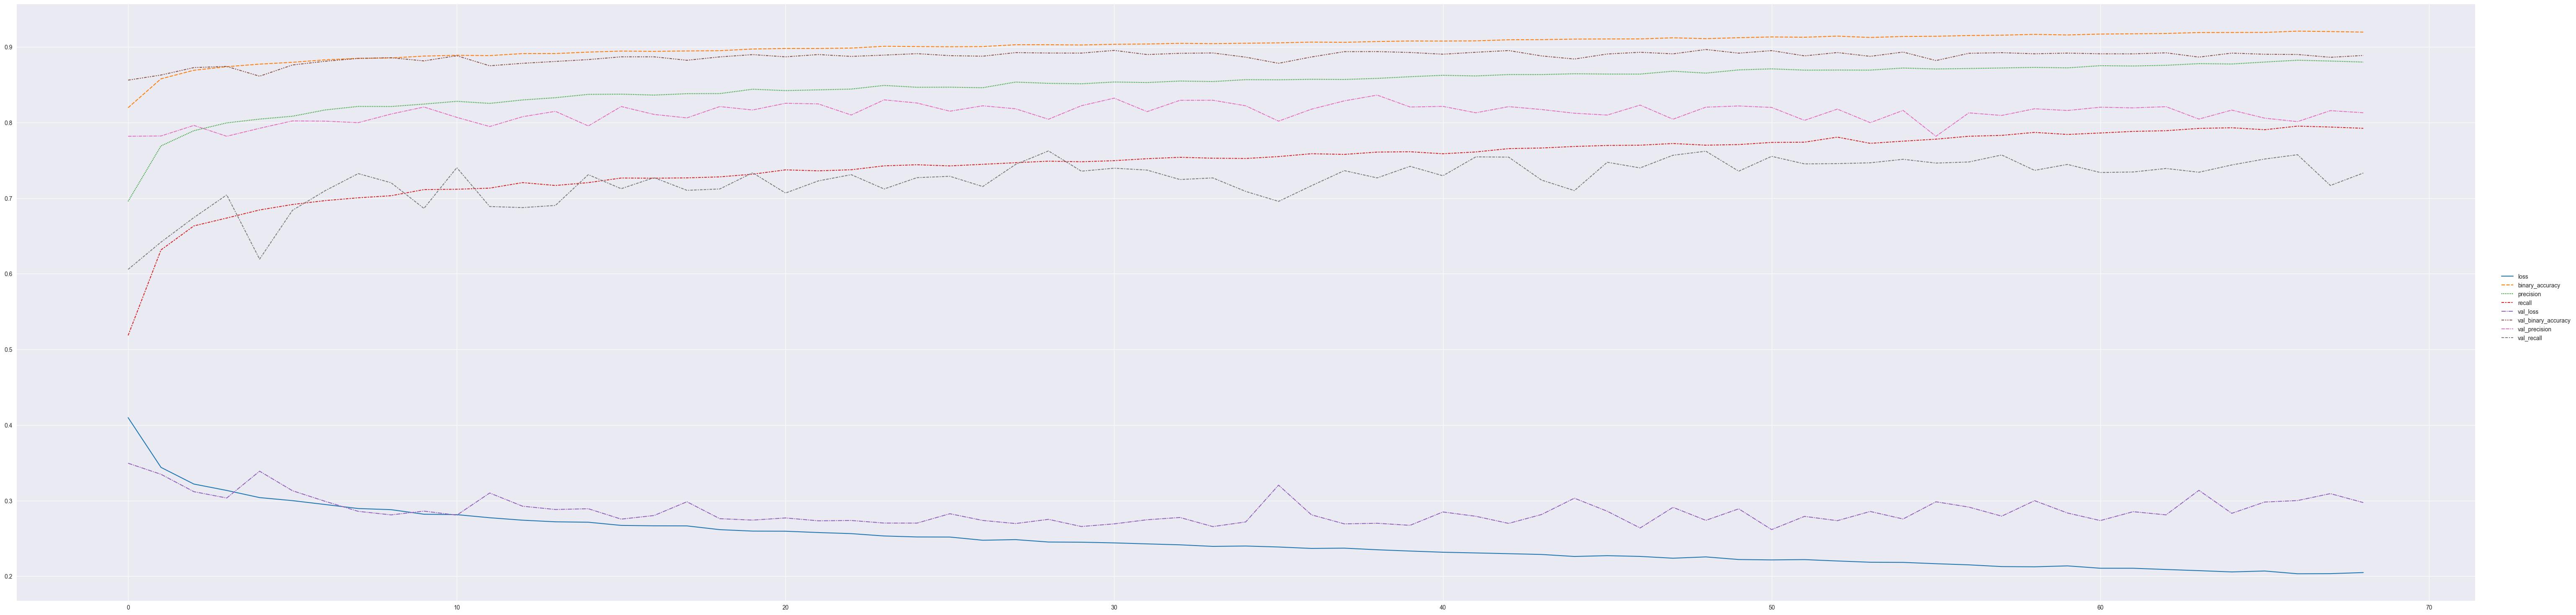

In [129]:
sns.relplot(data=pd.DataFrame(history.history), kind='line', height=15, aspect=4)
plt.show()

In [77]:
model02.evaluate([X_test, Y_test], Z_test)

69/69 [==============================] - 2s 30ms/step - loss: 0.2759 - binary_accuracy: 0.8921 - precision: 0.8129 - recall: 0.7476


[0.27588537335395813,
 0.8920563459396362,
 0.8128882050514221,
 0.7475901246070862]

# Оценка моделей

In [78]:
import sys
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

import sklearn.metrics

sns.set_style('darkgrid')

In [79]:
NUMPY_DATA_FILE = r'D:\Python_proj\test2\innopolis\ITOG\second/data.npz'

thismodule = sys.modules[__name__]

with np.load(NUMPY_DATA_FILE) as data:
    for k in data.keys():
        setattr(thismodule, k, data[k].astype(float))

In [80]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Class - " + class_label)

In [81]:
model01 = keras.models.load_model(r'D:\Python_proj\test2\innopolis\ITOG\second\calc/model01.keras')
model02 = keras.models.load_model(r'D:\Python_proj\test2\innopolis\ITOG\second\calc/model02.keras')

labels=['NORM', 'MI', 'STTC', 'CD', 'HYP']

Z_test = Z_test.astype(int)
Z_pred_01 = model01.predict(X_test).round().astype(int)
Z_pred_02 = model02.predict([X_test, Y_test]).round().astype(int)


69/69 [==============================] - 2s 31ms/step


## Отчет о классификации для model01

И есть подробный обзор результатов для model01. Вы можете посмотреть матрицы для всех меток и отчет о классификации.
Это первая модель, которая пытается предсказать цели, используя только набор данных метаданных - X dataset. Как вы можете видеть, я могу предсказать только показатели NORM и MI соответственно. Это очень плохой результат.

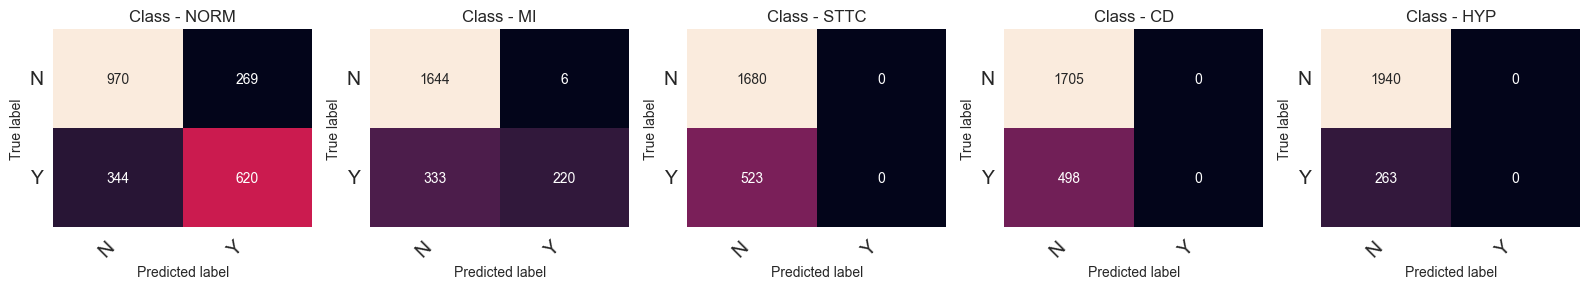

              precision    recall  f1-score   support

        NORM       0.70      0.64      0.67       964
          MI       0.97      0.40      0.56       553
        STTC       0.00      0.00      0.00       523
          CD       0.00      0.00      0.00       498
         HYP       0.00      0.00      0.00       263

   micro avg       0.75      0.30      0.43      2801
   macro avg       0.33      0.21      0.25      2801
weighted avg       0.43      0.30      0.34      2801
 samples avg       0.38      0.35      0.36      2801



In [82]:
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
    
for axes, cfs_matrix, label in zip(ax.flatten(), sklearn.metrics.multilabel_confusion_matrix(Z_test, Z_pred_01), labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

print(sklearn.metrics.classification_report(Z_test, Z_pred_01, target_names=labels, zero_division=0))

## Отчет о классификации для model02
Вторая модель использует набор данных метаданных X и набор данных кривых ЭКГ Y. 

Результаты лучше по сравнению с model01. Я могу предсказать все метки. Оценивая точность метрики, я могу хорошо предсказать все метки. С другой стороны, глядя на показатель отзыва, я не могу успешно классифицировать ярлыки CD и HYP соответственно. Это может быть проблемой.

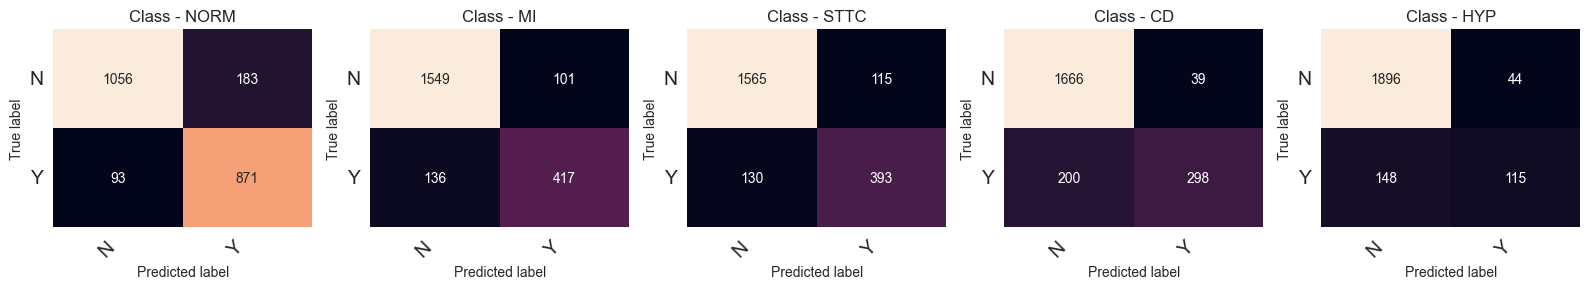

              precision    recall  f1-score   support

        NORM       0.83      0.90      0.86       964
          MI       0.81      0.75      0.78       553
        STTC       0.77      0.75      0.76       523
          CD       0.88      0.60      0.71       498
         HYP       0.72      0.44      0.55       263

   micro avg       0.81      0.75      0.78      2801
   macro avg       0.80      0.69      0.73      2801
weighted avg       0.81      0.75      0.77      2801
 samples avg       0.79      0.76      0.76      2801



In [83]:
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
    
for axes, cfs_matrix, label in zip(ax.flatten(), sklearn.metrics.multilabel_confusion_matrix(Z_test, Z_pred_02), labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

print(sklearn.metrics.classification_report(Z_test, Z_pred_02, target_names=labels, zero_division=0))

In [112]:
pd.DataFrame(Z_pred_02)

,0,1,2,3,4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2198,1,0,0,0,0
2199,0,0,0,1,0
2200,0,0,0,0,0
2201,0,0,0,0,0


In [113]:
Z_test

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
9,1,0,0,0,0
38,1,0,0,0,0
40,1,0,0,0,0
57,1,0,0,0,0
59,1,0,0,0,0
...,...,...,...,...,...
21809,1,0,0,0,0
21812,0,0,0,1,0
21818,1,0,0,0,0


In [127]:
!pip install graphviz


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [128]:
tf.keras.utils.plot_model(
model02,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
